# Sensitivity Analysis- No Histogram Equalization


In [1]:
## module imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
from scipy.spatial.distance import cdist
import skimage
import skimage.io
from skimage.exposure import histogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples

import sys
sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

In [2]:
feature_path = Path('data','features','VGG16_fc1_features_NoHistEQ.pickle')
assert feature_path.is_file()

le_path = Path('models','label_encoder.pickle')
assert le_path.is_file()


with open(feature_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)

## Dimension reduction
 

variance preserved by 50 components: 0.767


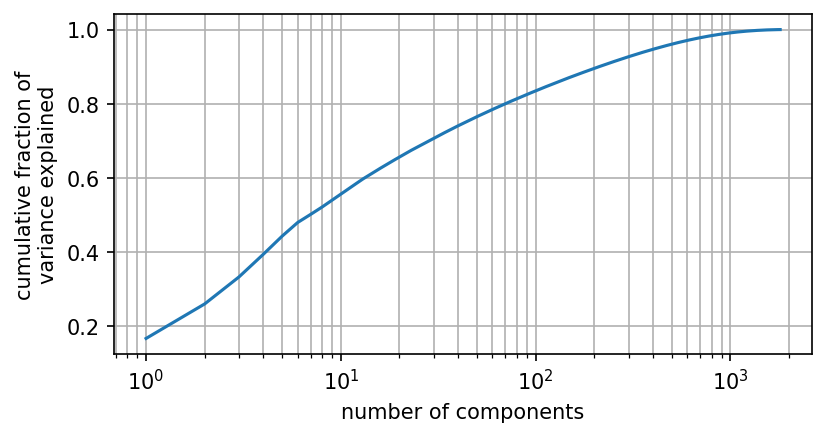

In [4]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1)

var_ = pca_n.explained_variance_ratio_.cumsum()


fig, ax = plt.subplots(figsize=(6,3),dpi=150,)
ax.grid('on', which='both')
ax.plot(range(1,len(var_)+1), var_)
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative fraction of\nvariance explained')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))

In [5]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

In [6]:
tsne = TSNE(n_components=2, random_state=605196619)
tsne_w = TSNE(n_components=2, random_state=3618296892)
x_nw_tsne = tsne.fit_transform(x_nw)
x_w_tsne = tsne_w.fit_transform(x)

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


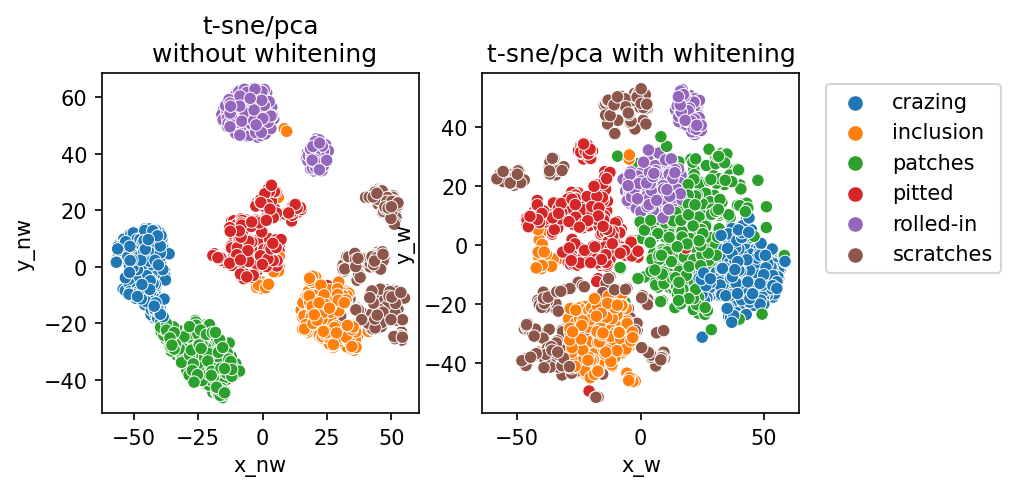

In [7]:
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=le.labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=le.labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
plt.show()

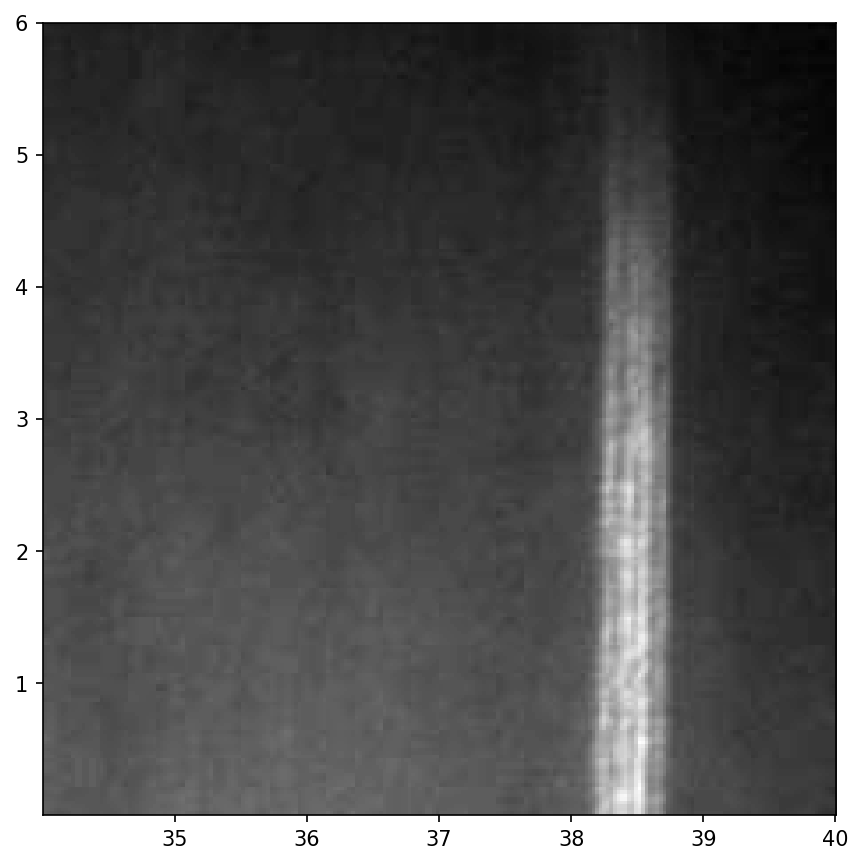

In [8]:
vis.pano_plot(x_nw_tsne[:,0], x_nw_tsne[:,1], files)


## Clustering 

In [9]:
kmeans = KMeans(n_clusters=8, init='k-means++', 
                n_init=500,random_state=3831647997)
kmeans.fit(x)
labels_unmatched = kmeans.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred = ct.label_matcher(labels_unmatched, y_gt,)  # this function matches the labels so we can compare directly
print('inertia: {:.2f}'.format(kmeans.inertia_))

inertia: 79311.48


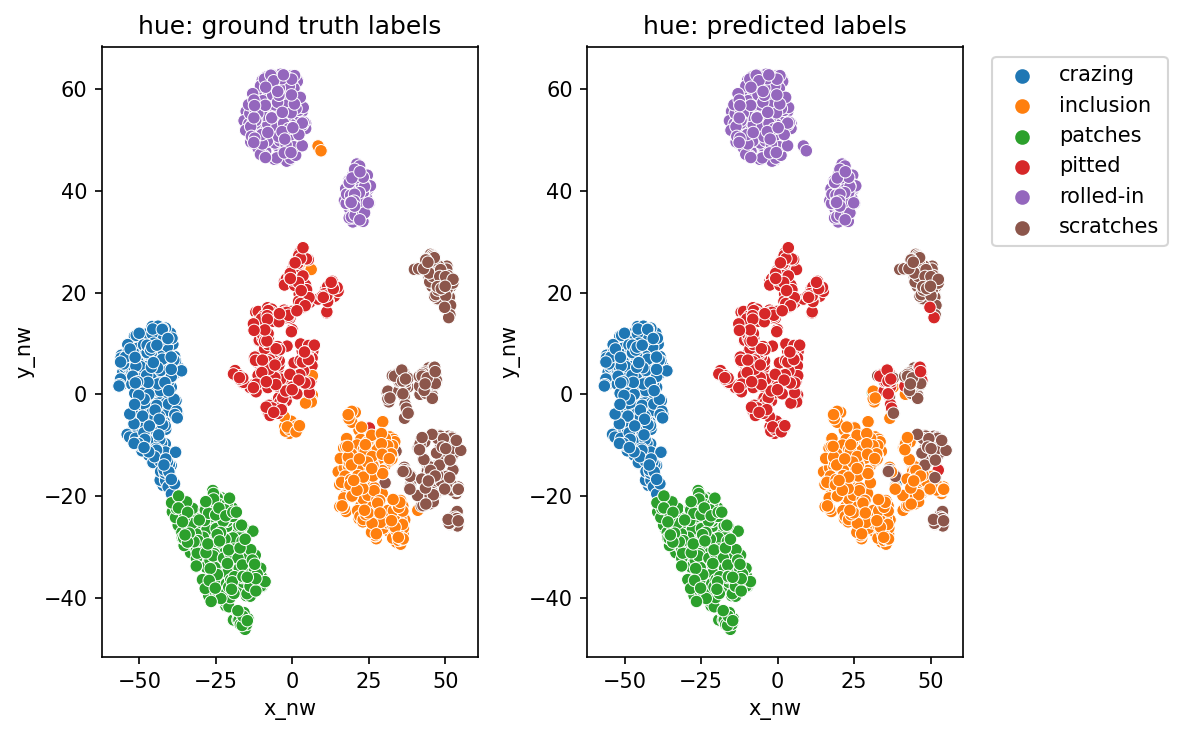

In [10]:
y_pred_str = le.inverse_transform(y_pred)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=le.labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=le.labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('hue: ground truth labels')
ax[1].set_title('hue: predicted labels')
fig.tight_layout()
plt.show()

C:\Users\91800\Documents\MTP\helper\visualize.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
C:\Users\91800\Documents\MTP\helper\visualize.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


Accuracy: 0.912


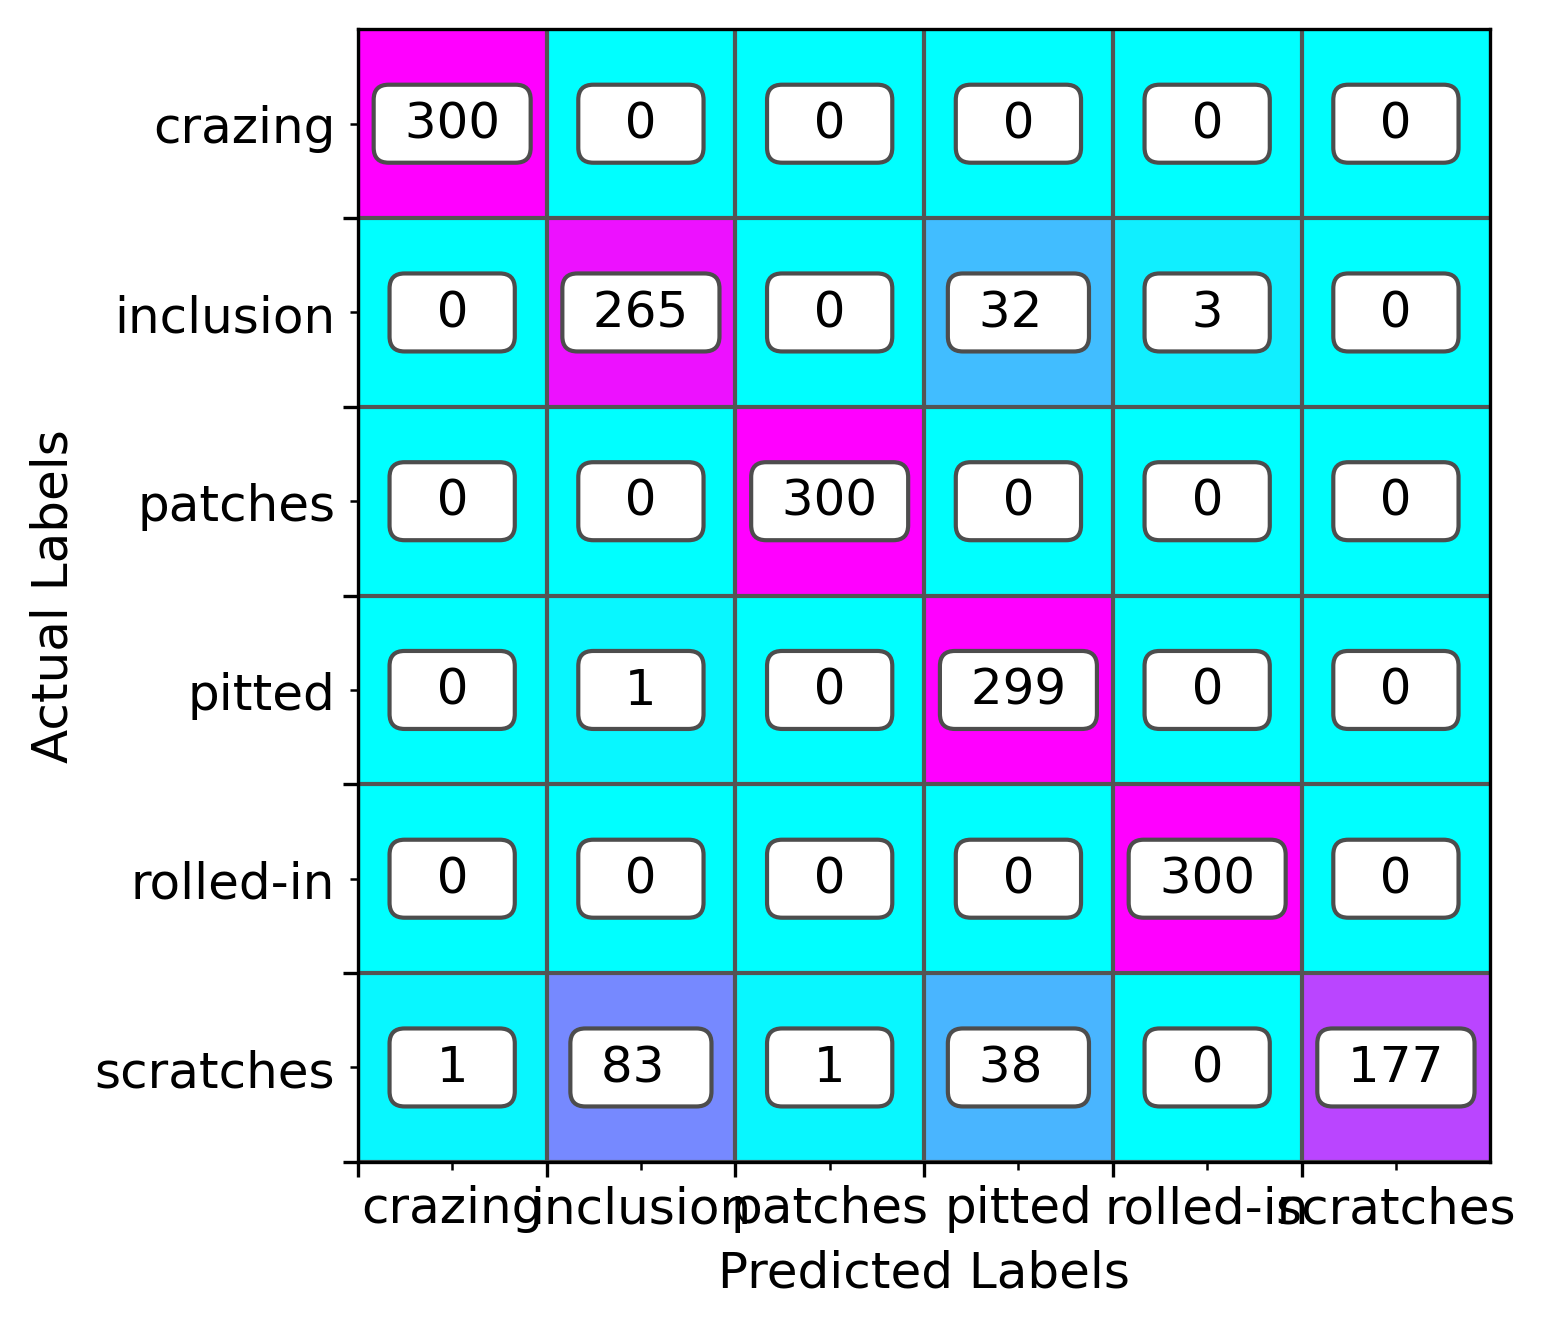

In [11]:
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
fig, ax = plt.subplots(dpi=300, figsize=(5,5))
vis.pretty_cm(CM, le.labels_ordered, ax0=ax, fs=12)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

In [14]:
# This takes a couple minutes to run, be patient!
nohisteq_10run_cache_path = Path('.neu_cache','nohisteq_10runs.pickle')
use_cache=True

if not use_cache or not nohisteq_10run_cache_path.is_file():
    rs = np.random.RandomState(seed=987654321)
    accuracies = np.zeros(10)
    for i, seed in enumerate(rs.randint(2**16, size=10)):
        kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
        kmeans_.fit(x)
        labels_unmatched_ = kmeans_.labels_
        y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
        accuracies[i] = (y_pred_ == y_gt).sum()/len(y_gt)
    
    with open(nohisteq_10run_cache_path, 'wb') as f:
        pickle.dump(accuracies, f)
else:
    with open(nohisteq_10run_cache_path, 'rb') as f:
        accuracies = pickle.load(f)
    


print(accuracies)

[0.91444444 0.86777778 0.84722222 0.88111111 0.855      0.95055556
 0.875      0.88444444 0.94666667 0.91055556]


In [15]:
print('10 runs:\n\tavg: {:.4f}\n\tstd: {:.4},\n\tmin: {:.4f}'.format(accuracies.mean(), np.std(accuracies), accuracies.min()))

10 runs:
	avg: 0.8933
	std: 0.03417,
	min: 0.8472


In [17]:
nohisteq_accvsk_cache_path = Path('.neu_cache','nohisteq_accvsk.pickle')
use_cache = True

if not use_cache or not nohisteq_accvsk_cache_path.is_file():
    rs = np.random.RandomState(seed=723271629)
    k_values = np.arange(7,16) 
    accuracies_k = np.zeros(len(k_values))

    for i, (k, state) in enumerate(zip(k_values, rs.randint(2**16, size=len(k_values)))):
        kmeans_ = KMeans(n_clusters=k, init='k-means++', n_init=500,
                         random_state=state)
        kmeans_.fit(x)
        labels_unmatched_ = kmeans_.labels_
        y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
        accuracies_k[i] = (y_pred_ == y_gt).sum()/len(y_gt)
    
    with open(nohisteq_accvsk_cache_path, 'wb') as f:
        pickle.dump({'k_values': k_values, 'accuracies_k': accuracies_k}, f)
else:
    with open(nohisteq_accvsk_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        k_values = results_['k_values']
        accuracies_k = results_['accuracies_k']

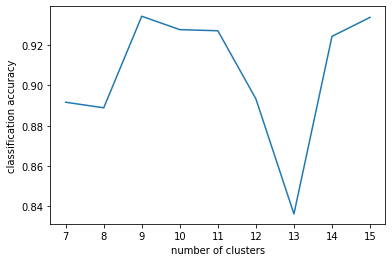

max accuracy: 0.934
num clusters: 9


In [18]:
fig, ax = plt.subplots()
ax.plot(k_values, accuracies_k)
ax.set_xlabel('number of clusters')
ax.set_ylabel('classification accuracy')
plt.show()
print('max accuracy: {:.3f}\nnum clusters: {}'.format(accuracies_k.max(),
                                        k_values[accuracies_k.argmax()]))

In [19]:
accuracies_k


array([0.89166667, 0.88888889, 0.93444444, 0.92777778, 0.92722222,
       0.89333333, 0.83611111, 0.92444444, 0.93388889])

In [26]:
# from the t-sne plot, the two RS clusters can separate based on their y-value 
# y = 20 perfectly separates the clusters

rs_label = le.transform(['inclusion'])[0]
RSgroup1 = np.logical_and(x_nw_tsne[:,1] > 20, 
                          y_gt==rs_label)
RSgroup2 = np.logical_and(x_nw_tsne[:,1] < 20, 
                          y_gt==rs_label)

In [27]:
# to get the 'most typical' image from each cluster, we can select the
# point that is closest to the cluster centroid

x1_Rs1 = x_nw_tsne[RSgroup1]
x1_Rs2 = x_nw_tsne[RSgroup2]

i1 = cdist(x1_Rs1, 
        np.mean(x1_Rs1, axis=0)[np.newaxis, :]).argmin()
i2 = cdist(x1_Rs2, 
        np.mean(x1_Rs2, axis=0)[np.newaxis, :]).argmin()

In [28]:
labarray = np.asarray(labels)
filearray = np.asarray(files)

group1files = filearray[RSgroup1]
group2files = filearray[RSgroup2]

file1 = group1files[i1]
file2 = group2files[i2]

im1 = skimage.io.imread(file1)
im2 = skimage.io.imread(file2)

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


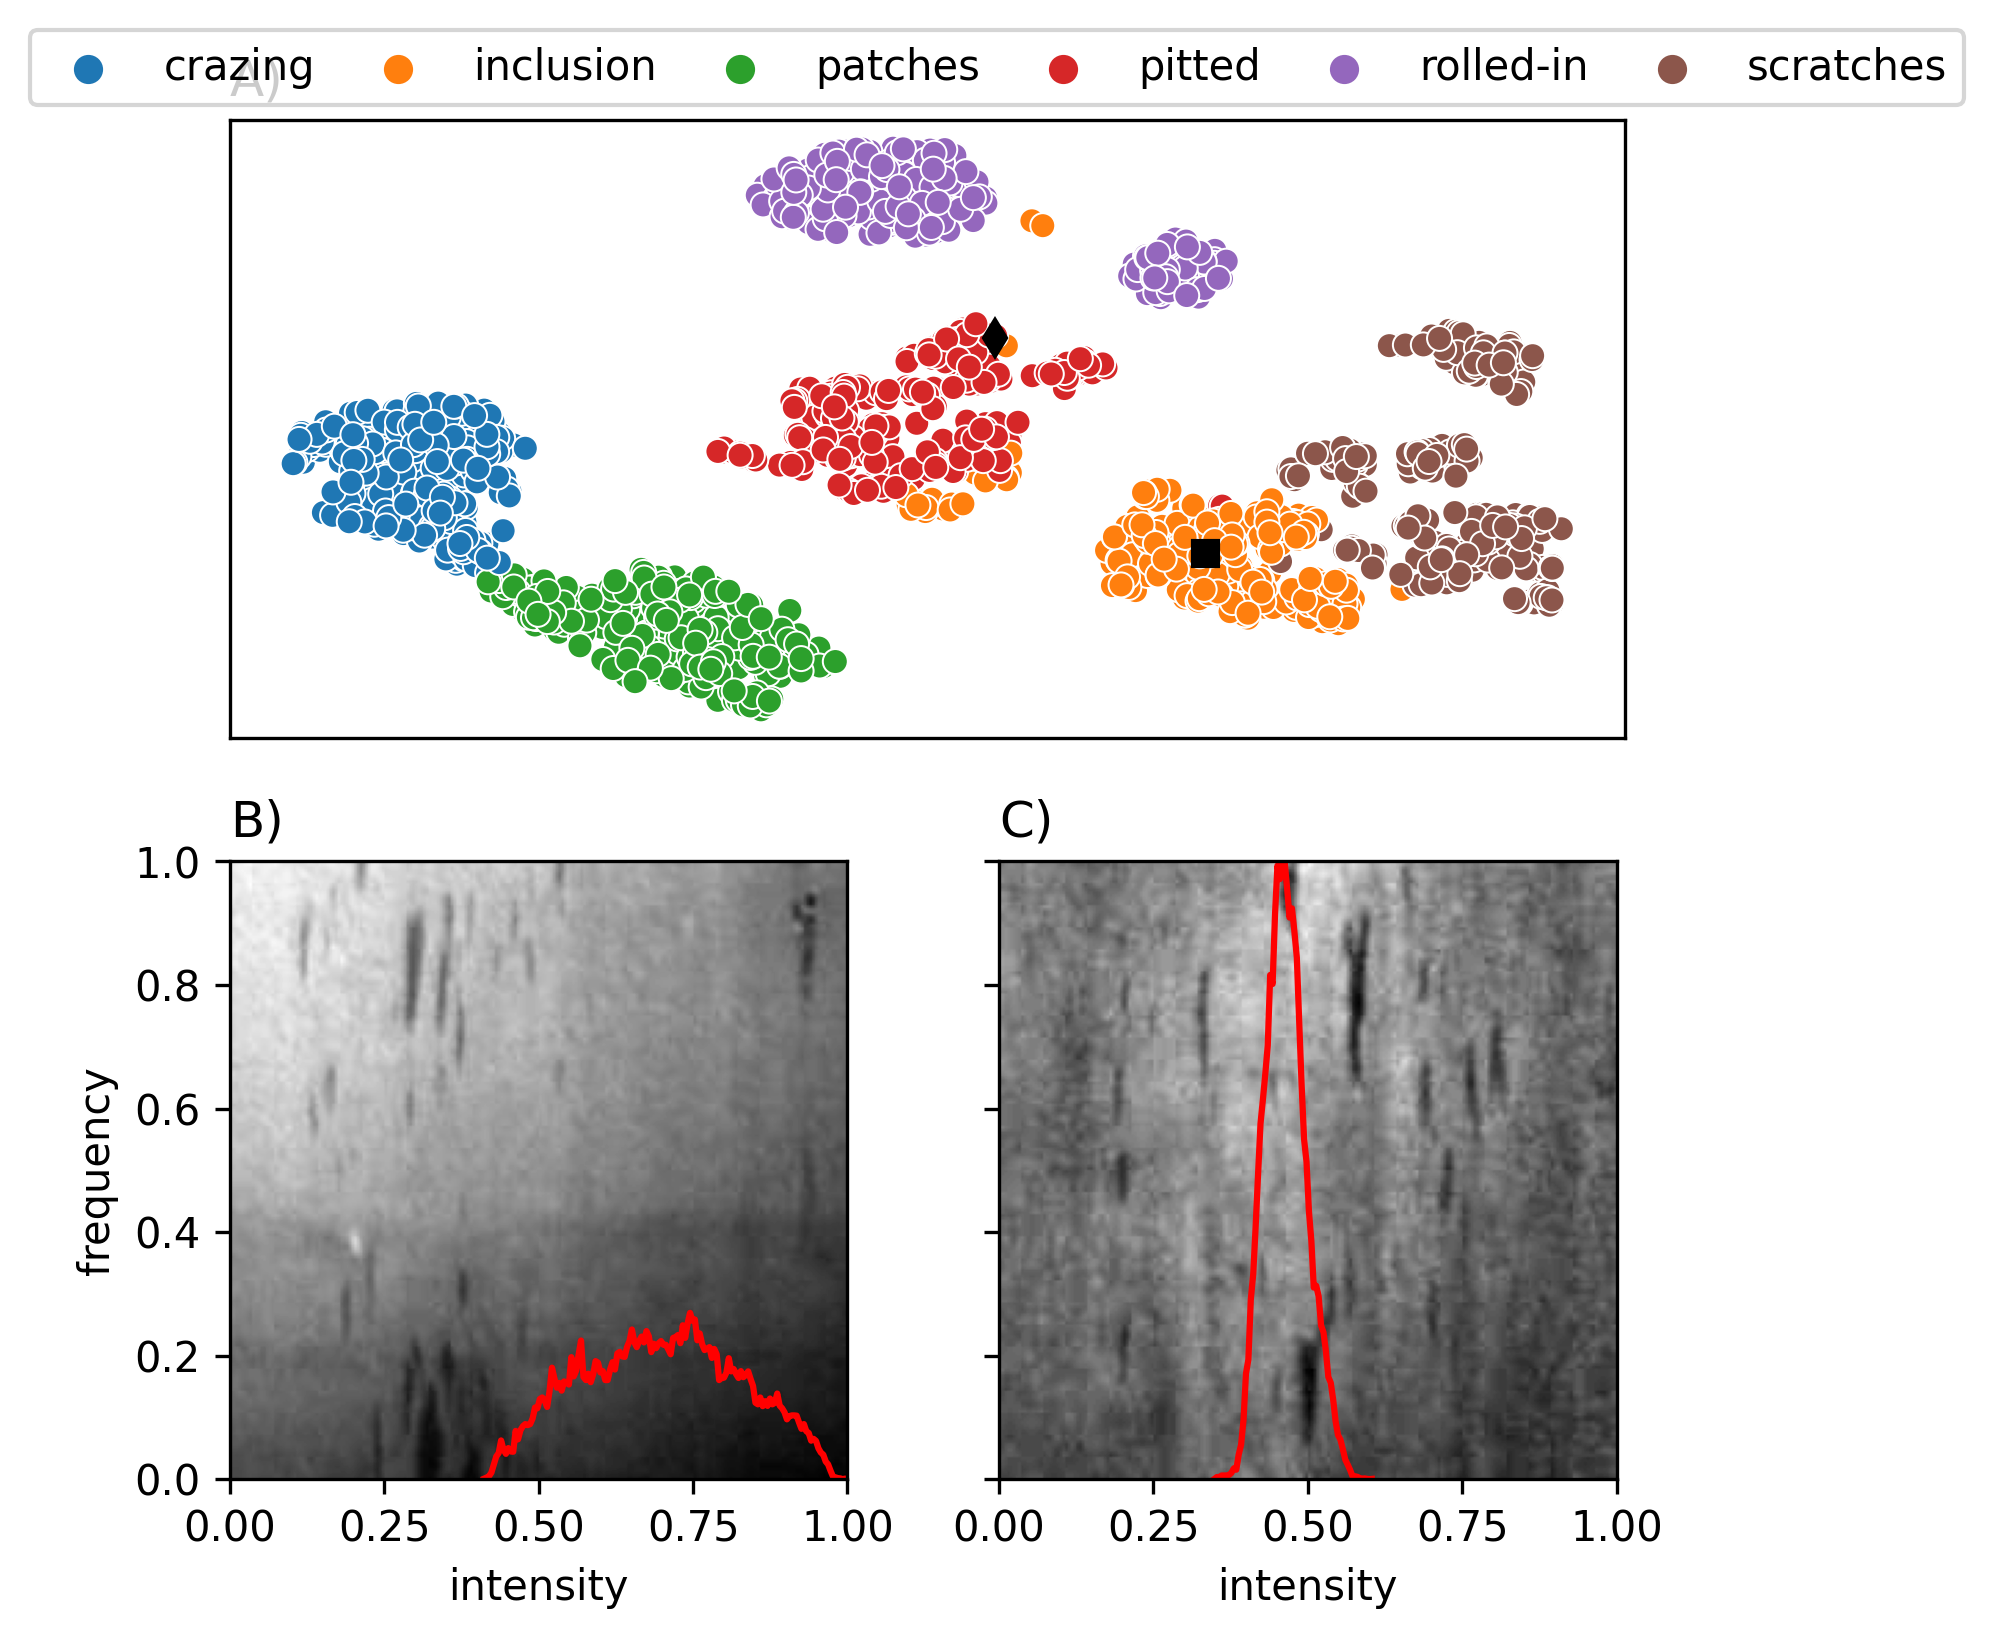

In [29]:
figure = plt.figure(figsize=(6,6), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=2)
ax1 = figure.add_subplot(gs[0,:])
ax2 = figure.add_subplot(gs[1,0])
ax3 = figure.add_subplot(gs[1,1])
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, hue_order=le.labels_ordered, ax=ax1)
l1 = ax1.legend(loc='upper center', ncol=6,
                bbox_to_anchor=(0.55,1.18), columnspacing=1)
ax1.plot(x1_Rs1[i1,0], x1_Rs1[i1,1], 'kd')
ax1.plot(x1_Rs2[i2,0], x1_Rs2[i2,1], 'ks')

ax1.set_xticks([])
ax1.set_yticks([])

h1, b1 = histogram(im1)
h2, b2 = histogram(im2)

hmax = max(h1.max(), h2.max())

ax2.imshow(im1, cmap='gray', extent=(0,1,0,1))
ax2.plot(b1/255, h1/hmax, 'r')
ax2.set_xlabel('intensity')
ax2.set_ylabel('frequency')
ax3.imshow(im2, cmap='gray', extent=(0,1,0,1))
ax3.plot(b2/255, h2/hmax, 'r')
ax3.set_yticklabels('')
ax3.set_xlabel('intensity')

bb = ax1.get_position()
ax2.set_position((0.125, *ax2.get_position().bounds[1:]))


ax1.set_title('A)', loc='left')
ax2.set_title('B)', loc='left')
ax3.set_title('C)', loc='left')
fig.tight_layout()
fig_path = Path('..','Figures')
fig.savefig(fig_path, bbox_inches='tight')

In [30]:
state=1341411652
kmeans_ = KMeans(n_clusters=12, init='k-means++', n_init=500,
                         random_state=state)
kmeans_.fit(x)
labels_unmatched_ = kmeans_.labels_
y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)

In [31]:
y_pred_multi_ = ct.label_matcher_multicluster(labels_unmatched_, y_gt, le)


In [32]:
(b1/255)[h1.argmax()]


0.7450980392156863

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


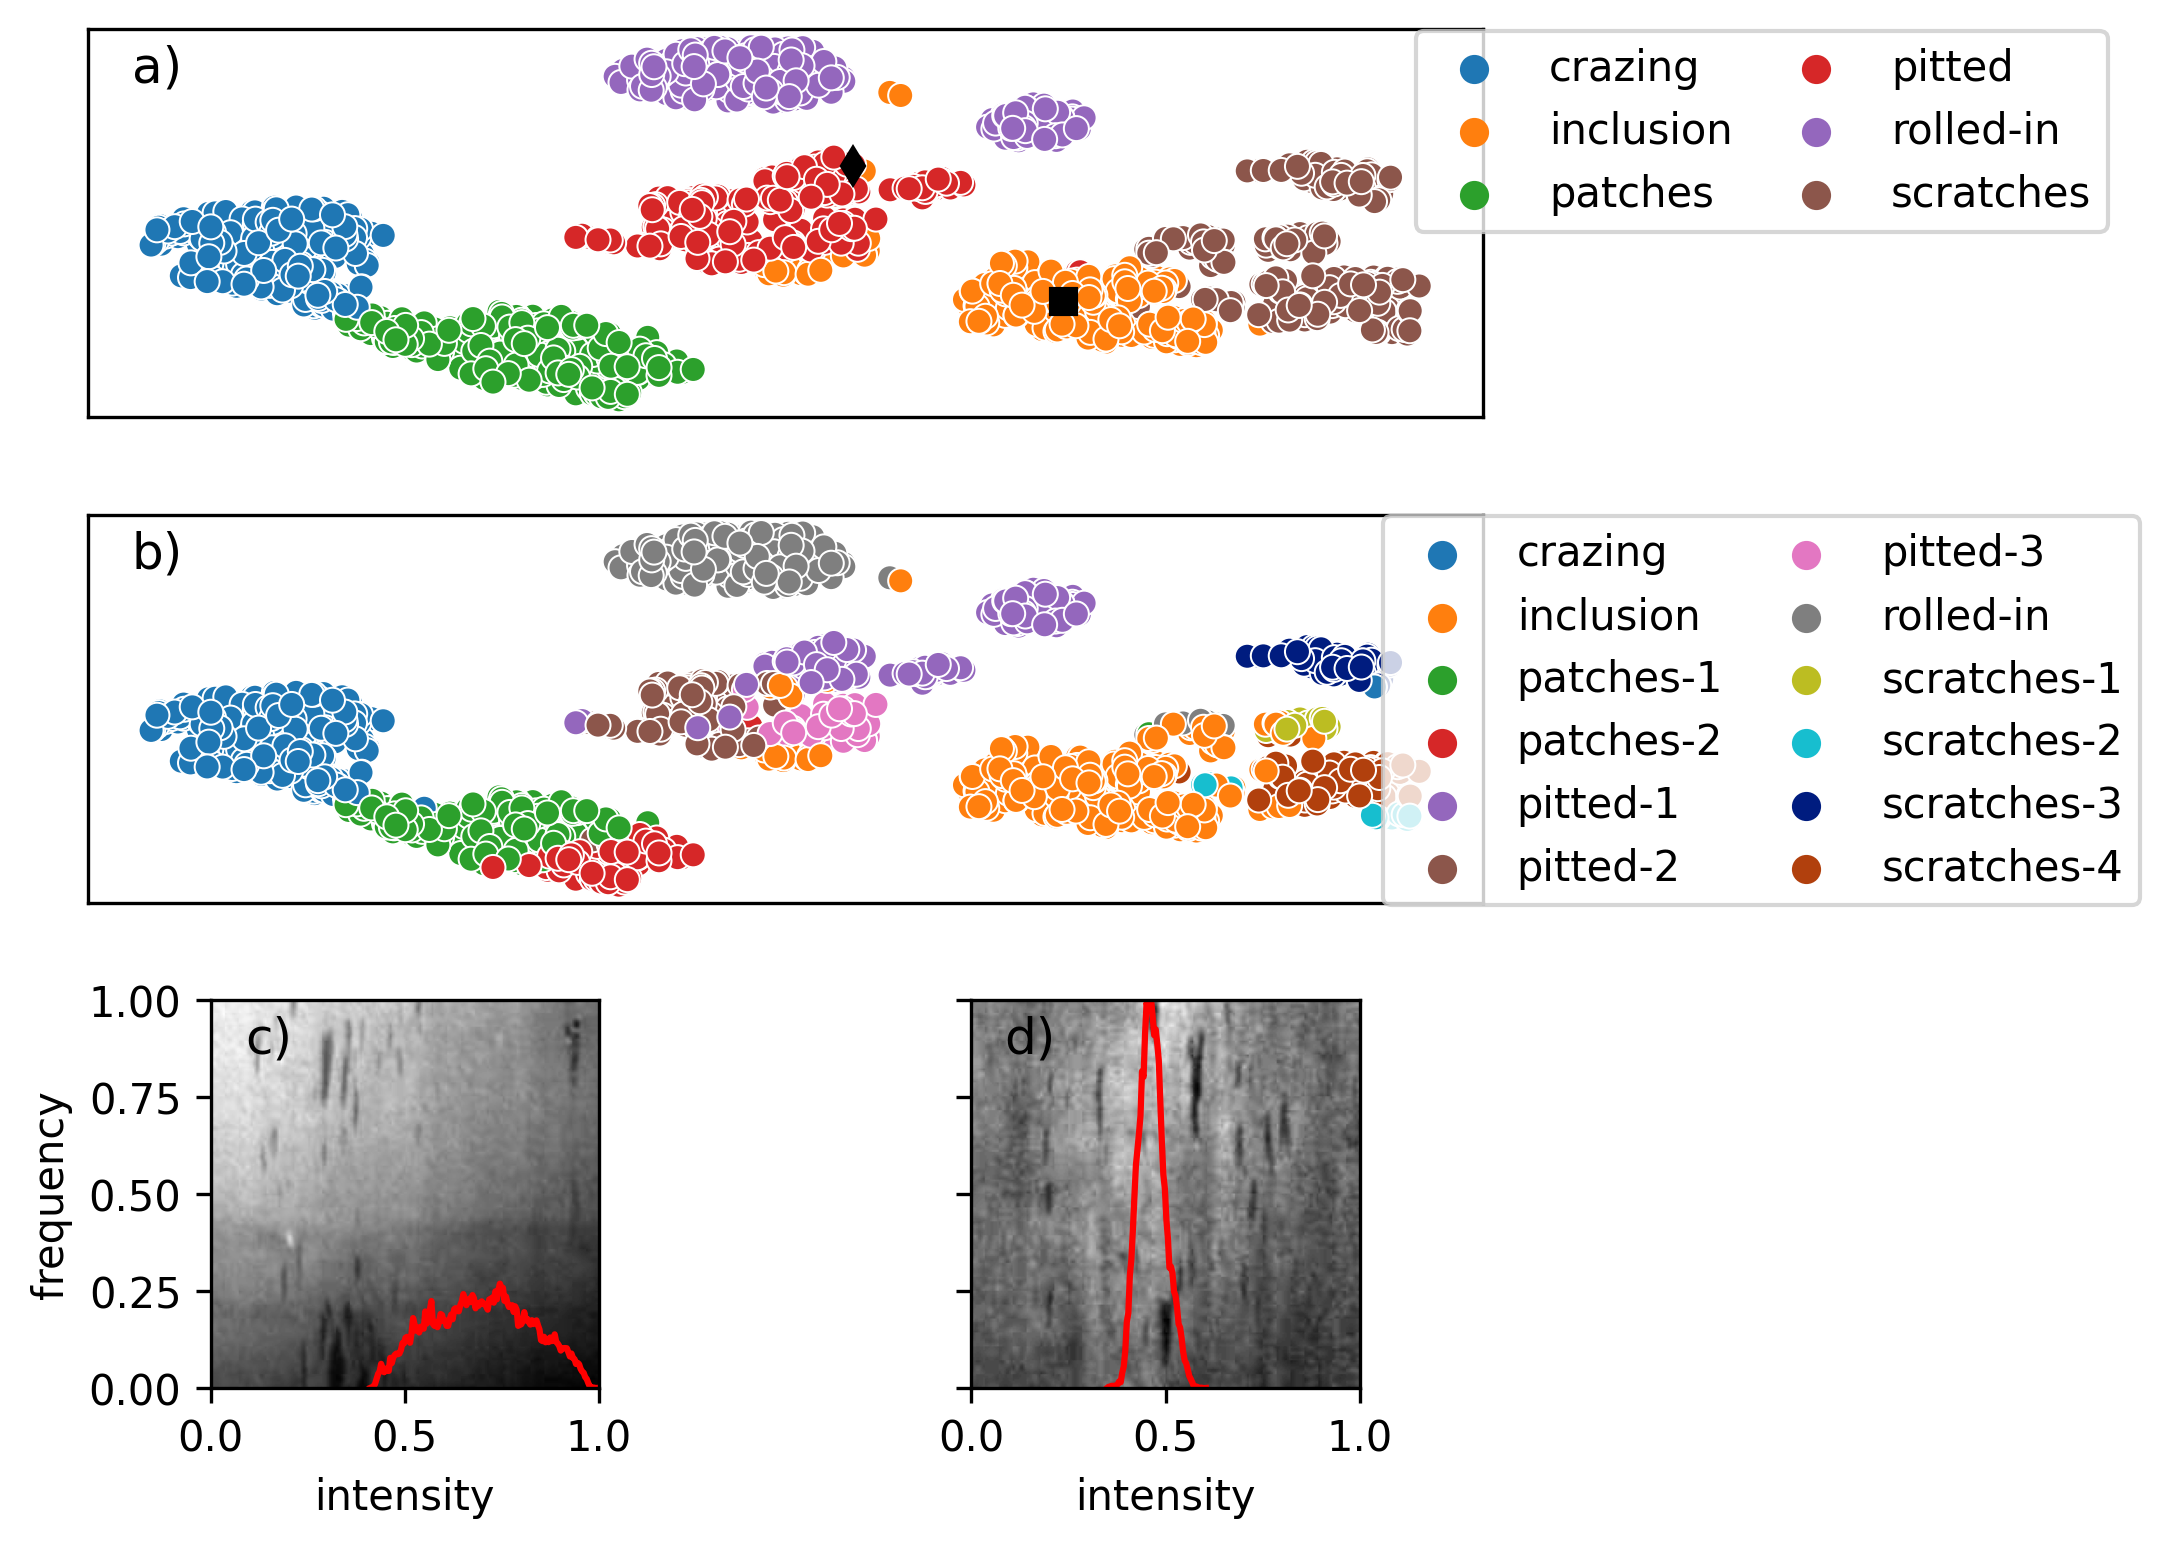

In [34]:
fig= plt.figure(figsize=(6,6), dpi=300, facecolor='w')
gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.25, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])



sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, hue_order=le.labels_ordered, 
                ax=ax1,)
l1 = ax1.legend(loc='upper center', ncol=2,
                 bbox_to_anchor=(1.2,1.05), columnspacing=1)

colors = np.concatenate([sns.color_palette(), sns.color_palette('dark', 2)], axis=0)
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=y_pred_multi_, hue_order=sorted(np.unique(y_pred_multi_), key=lambda x : x.upper()), 
                ax=ax2, palette=list(colors))
l2 = ax2.legend(loc='upper center', ncol=2,
                bbox_to_anchor=(1.2,1.05), columnspacing=1)

ax1.plot(x1_Rs1[i1,0], x1_Rs1[i1,1], 'kd')
ax1.plot(x1_Rs2[i2,0], x1_Rs2[i2,1], 'ks')


for a in [ax1, ax2]:
    a.set_xticks([])
    a.set_yticks([])




ax3.imshow(im1, cmap='gray', extent=(0,1,0,1))
ax3.plot(b1/255, h1/hmax, 'r')
ax3.set_xlabel('intensity')
ax3.set_ylabel('frequency')
ax4.imshow(im2, cmap='gray', extent=(0,1,0,1))
ax4.plot(b2/255, h2/hmax, 'r')
ax4.set_yticklabels('')
ax4.set_xlabel('intensity')


ax1.set_title('a)', **{'x':0.05,'y':0.80})
ax2.set_title('b)', **{'x':0.05,'y':0.80})
ax3.set_title('c)', **{'x':0.15,'y':0.80, 'color':'k'})
ax4.set_title('d)', **{'x':0.15,'y':0.80, 'color':'k'})

fig.savefig(Path('Figures','tsne_nohisteq.png'), bbox_inches='tight')
plt.show()

In [35]:
(b1/255)[h1.argmax()], (b2/255)[h2.argmax()]


(0.7450980392156863, 0.4588235294117647)

C:\Users\91800\Documents\MTP\helper\visualize.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
C:\Users\91800\Documents\MTP\helper\visualize.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


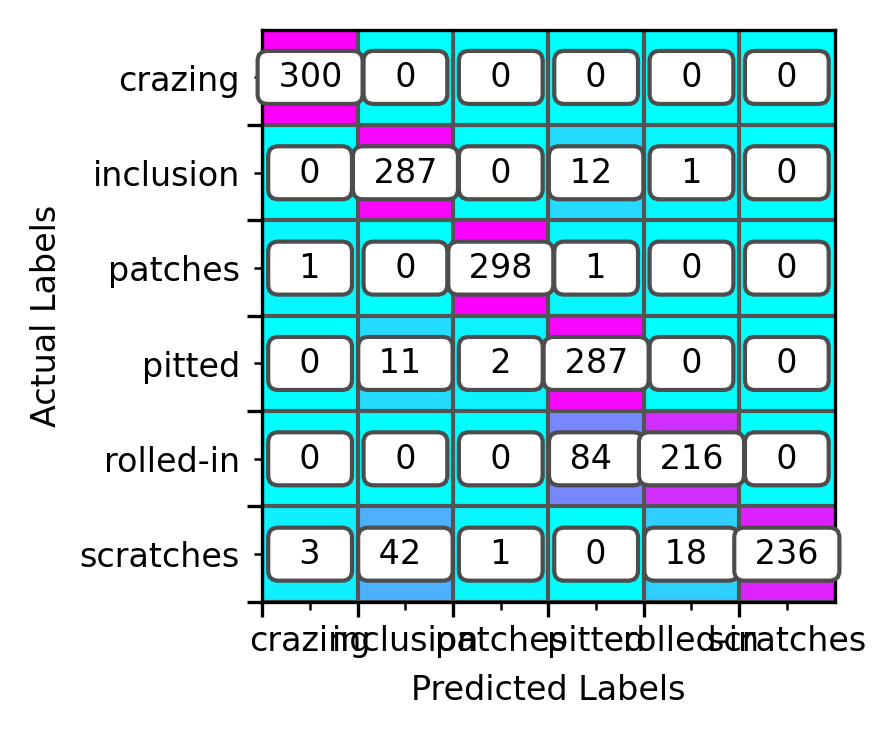

0.9022222222222223


In [37]:
cm_ = confusion_matrix(y_gt, y_pred_)
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
vis.pretty_cm(cm_, le.labels_ordered, ax0=ax, cmap='cool', fs=8)

fig.tight_layout()
fig.savefig(Path('Figures','no_histeq_cm.png'), bbox_inches='tight')
plt.show()

print(cm_.trace()/cm_.sum())

In [38]:
print(ct.latex_report(y_gt, y_pred_, le.labels_ordered))


\begin{tabular}{lcc}
	Class	& Precision	& Recall	\\  \hline 
	crazing	& 0.987 	& 1.000 	\\
	inclusion	& 0.844 	& 0.957 	\\
	patches	& 0.990 	& 0.993 	\\
	pitted	& 0.747 	& 0.957 	\\
	rolled-in	& 0.919 	& 0.720 	\\
	scratches	& 1.000 	& 0.787 	\\
\end{tabular}
